In [51]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

# Espectros A

In [52]:
def Minimos_cuadrados(x,y,n=1):
    l = x.shape[0]
    b = y
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)

    xsol = np.linalg.solve(AT,bT)
    
    return xsol

def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
        
    return y

def GetError(x,y,p,n=1):
    
    l = x.shape[0]
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    # Residuos
    R = y - np.dot(A,p)
    
    sigma2 = np.dot(R.T,R)/(len(y)-len(p))
    
    Cov = sigma2*np.linalg.inv(np.dot(A.T,A))
    
    R2 = None
    if np.shape(Cov) == (2,2):
        R2 = (Cov[0][1]**2)/(Cov[0][0]*Cov[1][1])

    return (Cov,R2,R)

def Get_sigma(Cov):
    sigmaai = np.sqrt(np.diagonal(Cov))
    return sigmaai[::-1]

def Error_relativo(X_real,X_exp):
    return (np.abs(X_exp - X_real)/X_real)

def presicion(d,v):
    p = (d/v)
    if p <= 0.1:
        return p,True
    else:
        return p,False
    
def exactitud(xr,xm,d):
    e = (np.abs(xr-xm))
    if e <= (2.5*d):
        return e/d,True
    else:
        return e/d,False

X = sym.Symbol('x',real=True)
Y = sym.Symbol('y',real=True)

In [53]:
c = 299798458*1e09 #nm/s
c_ = 299798458 #m/s
me = 0.51099895*1e06/(c**2) #eV/c**2
me_ = 0.51099895*1e06/(c_**2) #eV/c**2
mp = 938.27208816*1e06/(c**2) #eV/c**2
mn = 939.56542052*1e06/(c**2) #eV/c**2
h = 4.136667696*1e-15 #eV*s
h_barra = 6.582119569*1e-16 #eV*s
e_0 = 55.26349406*1e-03 #e**2/(cV*nm)
e = 1 #e
a_0 = 0.0529177210903 #nm
Ry = 13.605693122994 #eV
Miu_B = 5.7883818066*1e-05 #eV/T

# Datos

In [54]:
H_ = np.array([434.0472, 486.1298, 656.279])

Prisma:

In [55]:
a = np.pi/3
P = np.array([40.4, 40., 39.1])*(np.pi/180)

Rejilla:

In [56]:
R = np.array([14.2, 16., 22.3])*(np.pi/180)

Sodio:

In [57]:
S = 19.8*(np.pi/180)

# Análisis

Índice de refracción del prisma

In [58]:
def indice_n (d):
    return (np.sin((a+d)/2))*2

n = indice_n(P)
n

array([1.53656705, 1.53208889, 1.52194485])

Text(0.5, 1.0, 'Índice de refracción según longitud de onda')

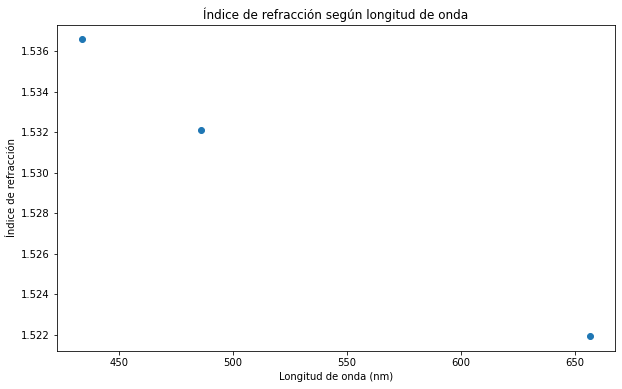

In [59]:
plt.figure(figsize=(10,6))
plt.scatter(H_,n)
plt.ylabel('Índice de refracción')
plt.xlabel('Longitud de onda (nm)')
plt.title('Índice de refracción según longitud de onda')

Text(0.5, 1.0, 'Índice de refracción según el inverso de longitud de onda al cuadrado')

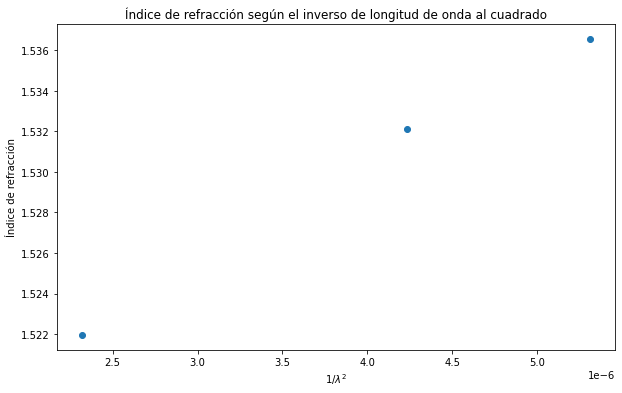

In [60]:
inv_cuadrado = 1/(H_**2)
plt.figure(figsize=(10,6))
plt.scatter(inv_cuadrado,n)
plt.ylabel('Índice de refracción')
plt.xlabel(r'$1/\lambda^{2}$')
plt.title('Índice de refracción según el inverso de longitud de onda al cuadrado')